In [8]:
import torch
from torch import nn
from torch.optim import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from transformers import BertTokenizer, BertModel
from tqdm import tqdm

In [9]:
#load pickle of us politicians and 
POLITICIANS_PICKLE_PATH = "../data/binary/us-politicians.pickle"
politicians = pd.read_pickle(POLITICIANS_PICKLE_PATH)
politicians.loc[politicians['party'] == 29552, 'party'] = 1
politicians.loc[politicians['party'] == 29468, 'party'] = 0
politicians.head()

,speaker_id,quote_id,quotation,speaker,party,Date-Time
0,1282411,2015-06-11-000090,25-year cost estimate for the U.S. nuclear mod...,Ed Markey,1,2015-06-11
1,1282411,2015-08-11-090504,The state is transitioning to a higher percent...,Ed Markey,1,2015-08-11
2,1282411,2015-10-27-125840,This highly coveted TIGER grant funding would ...,Ed Markey,1,2015-10-27
3,1282411,2015-01-19-008025,carefully cutting the Gordian knot that has ti...,Ed Markey,1,2015-01-19
4,1282411,2015-12-09-094134,The amendments would improve the safety of agi...,Ed Markey,1,2015-12-09


In [10]:
#load pickle of labels
LABELS_CSV_PATH = "../classifier/data/join_result.csv"
labels = pd.read_csv(LABELS_CSV_PATH)
labels = labels.drop(labels[labels['label'] == 0].index)
labels.head()

,sentence,label
7,Our great middle class is hard-pressed.,704
8,"Millions of Americans have lost their jobs, an...",704
14,"We have a plan to build a strong, growing econ...",404
16,And we will honor the values of a strong Ameri...,201
24,"Alone among nations, America was born in pursu...",201


<function matplotlib.pyplot.show(close=None, block=None)>

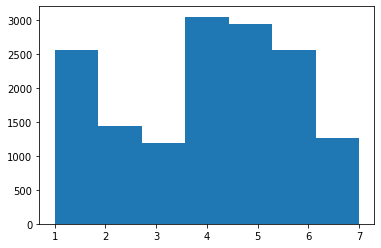

In [11]:
# Division by topic:
# 1: External Relations
# 2: Freedom and Democracy
# 3: Political System
# 4: Economy
# 5: Welfare and quality of life
# 6: Fabric of Society
# 7: Social Groups
topics = labels.copy()

for i in range(1, 8):
    topics.loc[ topics['label']//100 == i , 'label'] = i 

plt.hist(topics['label'], bins = 7)
plt.show

,sentence,label
7,Our great middle class is hard-pressed.,7
8,"Millions of Americans have lost their jobs, an...",7
14,"We have a plan to build a strong, growing econ...",4
16,And we will honor the values of a strong Ameri...,2
24,"Alone among nations, America was born in pursu...",2


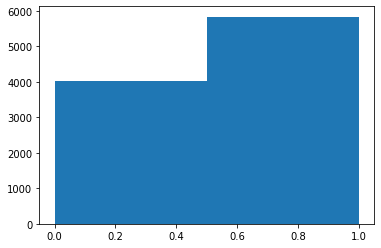

In [12]:
# Division by left/right:
# 0. Left
# 1. Right
labelLeftRight = {
    'right': [104,201,203,305,401,402,407,414,505,601,603,605,606],
    'left': [103,105,106,107,403,404,406,412,413,504,506,701,202]
    }
leftRight = labels.copy()
leftRight.loc[ leftRight['label'].isin(labelLeftRight['right']), 'label'] = 1
leftRight.loc[ leftRight['label'].isin(labelLeftRight['left']), 'label'] = 0
leftRight = leftRight.drop(leftRight[(leftRight['label'] != 0) & (leftRight['label'] != 1)].index)

plt.hist(leftRight['label'], bins = 2)
plt.show
topics.head()

In [13]:
def clean_txt(txt):
    txt = re.sub("'","",txt)
    txt = re.sub("(\\W)+"," ",txt)
    return txt

topics['sentence'] = topics['sentence'].apply(clean_txt)

In [14]:

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = list(df['label'])
        self.texts = [tokenizer(text, padding='max_length', max_length = 512, truncation=True,return_tensors="pt") for text in df['sentence']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [15]:
np.random.seed(112)
df_train, df_val, df_test = np.split(topics.sample(frac=1, random_state=42),
                                     [int(.8*len(topics)), int(.9*len(topics))])

print(len(df_train),len(df_val), len(df_test))

11997 1500 1500


In [16]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer




In [17]:
def train_model(model_bert, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model_bert.parameters(), lr= learning_rate)

    if use_cuda:

            model_bert = model_bert.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):
                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model_bert(input_id, mask)

                batch_loss = criterion(output.long(), train_label.long())
                total_loss_train += batch_loss.item()

                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model_bert.zero_grad()
                batch_loss.backward()
                optimizer.step()

            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model_bert(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    a=23
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')

EPOCHS = 5
model = BertClassifier()
LR = 1e-6

train_model(model, df_train, df_val, LR, EPOCHS)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|          | 0/5999 [00:06<?, ?it/s]


RuntimeError: "host_softmax" not implemented for 'Long'